### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге.

Ваше решение тут

1) $ -\frac{\partial L}{\partial F}(x_i, F_{k-1}(x_i)))^N_{i=1} = -\frac{(y_i - a(x_i))^2}{\partial a(x_i)} = -2(y_i - a(x_i)) $

2) $-\frac{\partial  exp(-a(x_i)  y_i)}{\partial a(x_i)} = exp(-a(x_i)  y_i) y_i$

3) $-\frac{\partial  \log (1 + exp( -a(x_i) y_i)) }{\partial a(x_i)} = -\frac{1}{1 + exp( -a(x_i) y_i)} \frac{\partial  (1 + exp(-a(x_i)  y_i))}{\partial a(x_i)} = \frac{y_i}{1 + exp(a(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LinearRegression

/home/simon/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
class MyGradientBoostingClassifier:

    def __init__(self,
                 loss='mse',
                 learning_rate=0.1,
                 n_estimators=3,
                 colsample=1.0,
                 subsample=1.0,
                 *args, **kwargs):
        """
        loss -- один из 3 лоссов: mse, exp, log
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self._F = []

    def _g(self, Fx, y):
        if self.loss == 'mse':
            return 2 * (y - Fx)
        if self.loss == 'exp':
            return np.exp(-Fx * y) * y
        if self.loss == 'log':
            return y / (1 + np.exp(Fx * y))

    def _sub(self, X, y):
        """
        для выделения процента рандомных признаков/объектов
        """
        if self.subsample == 1.0:
            _X = X
            _y = y
        else:
            end = X.shape[0]-1
            size = int(X.shape[0] * self.subsample)
            ind = np.random.randint(low=0, high=end, size=size)
            tmp = np.ones(X.shape)
            tmp[ind] = 0
            _X = X * tmp
            tmp = np.ones(y.shape)
            tmp[ind] = 0
            _y = y * tmp 
        if self.colsample != 1.0:
            tmp = [0 for i in range(X.shape[1])]
            _col = int(X.shape[1]*self.subsample)
            for i in range(_col):
                tmp[i] = 1
            for i in range(X.shape[0]):
                np.random.shuffle(tmp)
                _X[i] *= tmp
        return _X, _y
    
    def fit(self,
            X, y,
            base_model=DecisionTreeRegressor,
            init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        rate = self.learning_rate
        if init_model is None:
            # предсказываем как константа
            _X, _y = self._sub(X, y)
            prediction = np.mean(_y) * np.ones([_y.shape[0]])
        else:
            # предсказываем на базовой модели
            _model = init_model()
            _X, _y = self._sub(X, y)
            _model.fit(_X, _y)
            prediction = _model.predict(X)
            self._F.append(_model)
        for i in range(self.n_estimators):
            _model = base_model(*self.args, **self.kwargs)
            if i == 0 and init_model is None:
                target = _y
            else:
                target = self._g(prediction, _y)
            _X, _y = self._sub(X, y)
            _model.fit(_X, target)
            predict = _model.predict(_X)
            self._F.append(_model)
            prediction += self.learning_rate * predict

        
    def predict(self, X):
        # Ваш код здесь
        result = self._F[0].predict(X)
        for i in range(1, len(self._F)):
            pr = self._F[i].predict(X)
            result += self.learning_rate * pr
        return np.around(result)



In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [12]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8333333333333334
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
# # На моем компьютере первый импорт работает только с этим кодом
# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [9]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [10]:
# разделим для тестировки
X_trn, y_trn = X[20000:], y[20000:]
X_val, y_val = X[:20000], y[:20000]

## 1)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
scores = []
est = range(1, 30)

for e in est:
    my_clf = MyGradientBoostingClassifier(n_estimators=e)
    my_clf.fit(X_trn, y_trn)
    sc = accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val)
    scores.append(sc)

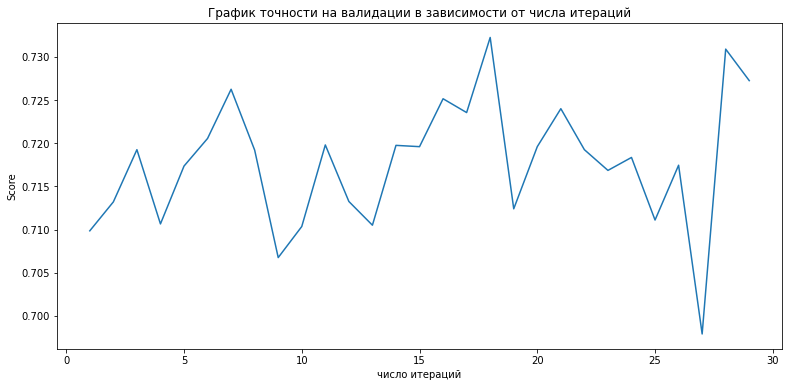

In [15]:
fig = plt.figure(figsize= (13,6))
ax = fig.add_subplot(111)
ax.set_title("График точности на валидации в зависимости от числа итераций")
ax.set_xlabel("число итераций")
ax.set_ylabel("Score")

ax.plot(est, scores)

In [ ]:
# for i in est:
#     print(i, scores[i-1])

## 2)

In [16]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

In [17]:
params = ['mse', 'exp', 'log']

mean = {i: 0 for i in params} # массив средних значений

for p in params:
    score = 0
    for tr, te in kfold.split(X, y):
        my_clf = MyGradientBoostingClassifier(loss=p)
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        my_clf.fit(X_tr, y_tr)
        predict = my_clf.predict(X_te)
        score += accuracy_score(y_pred=my_clf.predict(X_te), y_true=y_te)
    mean[p] = score/3
    
mean

{'mse': 0.8269864341085271,
 'exp': 0.8298449612403102,
 'log': 0.8255329457364341}

In [18]:
params = [0.05, 0.1, 0.2, 0.5, 1.0, 1.3]

mean = {i: 0 for i in params} # массив средних значений

for p in params:
    score = 0
    for tr, te in kfold.split(X, y):
        my_clf = MyGradientBoostingClassifier(learning_rate=p)
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        my_clf.fit(X_tr, y_tr)
        predict = my_clf.predict(X_te)
        score += accuracy_score(y_pred=my_clf.predict(X_te), y_true=y_te)
    mean[p] = score/3
    
mean

{0.05: 0.8281007751937985,
 0.1: 0.8312015503875969,
 0.2: 0.8285852713178294,
 0.5: 0.8354166666666667,
 1.0: 0.8326550387596899,
 1.3: 0.08880813953488371}

In [19]:
params = [0.4, 0.6, 0.8, 1]

mean = {i: 0 for i in params} # массив средних значений

for p in params:
    score = 0
    for tr, te in kfold.split(X, y):
        my_clf = MyGradientBoostingClassifier(colsample=p)
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        my_clf.fit(X_tr, y_tr)
        predict = my_clf.predict(X_te)
        score += accuracy_score(y_pred=my_clf.predict(X_te), y_true=y_te)
    mean[p] = score/3
    
mean

{0.4: 0.8274709302325581,
 0.6: 0.8242732558139535,
 0.8: 0.8311046511627906,
 1: 0.8272286821705426}

In [20]:
params = [0.4, 0.6, 0.8, 1]

mean = {i: 0 for i in params} # массив средних значений

for p in params:
    score = 0
    for tr, te in kfold.split(X, y):
        my_clf = MyGradientBoostingClassifier(subsample=p)
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        my_clf.fit(X_tr, y_tr)
        predict = my_clf.predict(X_te)
        score += accuracy_score(y_pred=my_clf.predict(X_te), y_true=y_te)
    mean[p] = score/3
    
mean

{0.4: 0.742877906976744,
 0.6: 0.7062015503875969,
 0.8: 0.6802325581395349,
 1: 0.8284399224806202}

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [21]:
def get_bootstrap_samples(X, y, n_samples=1.0):
    indices = np.random.randint(0, len(X), int(len(X)*n_samples))
    _X = X[indices]
    _y = y[indices]
    return _X, _y

In [22]:
N = 15
boosts = []

for i in range(N):
    X_bs, y_bs = get_bootstrap_samples(X_trn, y_trn, n_samples=0.3)
    my_clf = MyGradientBoostingClassifier()
    my_clf.fit(X_bs, y_bs, base_model=RandomForestRegressor)
    boosts.append(my_clf)

In [23]:
predict = None
for i in range(N):
    pre = boosts[i].predict(X_val)
    if predict is None:
        predict = np.zeros(pre.shape)
    predict += pre
pr = np.around(predict / N)

print(accuracy_score(y_pred=pr, y_true=y_val))

0.75595


In [24]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_trn, y_trn, base_model=RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val))

0.7525


Качество получилось незначительно улучшить. Скорее всего это благодаря большому колличеству моделей

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [25]:
# рандом форест
my_clf = MyGradientBoostingClassifier()
clf = MyGradientBoostingClassifier()
my_clf.fit(X_trn, y_trn, init_model=RandomForestRegressor)
clf.fit(X_trn, y_trn)
print(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))
print(accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val))

0.7109
0.75145


In [27]:
# линейная модель
my_clf = MyGradientBoostingClassifier()
clf = MyGradientBoostingClassifier()
my_clf.fit(X_trn, y_trn, init_model=LinearRegression)
clf.fit(X_trn, y_trn)
print(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))
print(accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val))

0.70705
0.75385


Качество получилось улучшить благодаря совокупности из различных моделей.  Если начальный предикт (модель) плохо работает с какими то данными, то уже другой предикт (другая модель) хорошо исправляет его ошибки


P.S. наверное любая модель лучше константного предсказания

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

